# Examples of Country Covariate Assignments to Measurements

In [31]:
# import libraries
import pandas as pd
import numpy as np
from cascade.input_data.configuration.construct_country import (
    assign_interpolated_covariate_values,
    convert_gbd_ids_to_dismod_values,
    get_covariate_data_by_sex,
)
from cascade.input_data.db.country_covariates import country_covariates
from cascade.input_data.db.demographics import get_all_age_spans
from cascade.testing_utilities import make_execution_context

In [5]:
# import plotting libraries
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [13]:
# globals

FEMALE = -0.5
MALE = 0.5
BOTH = 0

In [6]:
# create execution context
execution_context = make_execution_context()
execution_context.parameters.gbd_round_id = 5

In [8]:
# get covariate data for USA (102)
location_id = 102
demographics = dict(
    age_group_ids="all", year_ids="all", sex_ids="all", location_ids=[location_id]
)
age_groups = get_all_age_spans()

print("age groups")
print(list(age_groups.columns))
print(age_groups.shape)
print()

covariate_ids = [26, 14, 1241]
ccovs = {}

for covariate_id in covariate_ids:
    ccov_data = country_covariates(covariate_id, demographics, execution_context.parameters.gbd_round_id)
    ccov_ranges_df = convert_gbd_ids_to_dismod_values(ccov_data, age_groups)
    ccov_ranges_df["avg_age"] = ccov_ranges_df[["age_lower", "age_upper"]].mean(axis=1)
    ccov_ranges_df["avg_time"] = ccov_ranges_df[["time_lower", "time_upper"]].mean(axis=1)
    ccovs[covariate_id] = ccov_ranges_df

print(f"Retrieved covariate data for {len(ccovs)} covariates.")    

age groups
['age_group_id', 'age_group_years_start', 'age_group_years_end']
(407, 3)

Retrieved covariate data for 3 covariates.


### Example (2D interpolation over age and time): 
    Covariate is by_sex, by_age, and has multiple time values
    
    Measurement data has sex=male, female, and both, has an age value outside the interpolated range, and has a time value outside the interpolated range 

In [101]:
def make_at_3D_scatter_plot(cov, plot_title):
    
    fig = plt.figure()
    
    ax = plt.axes(projection='3d')
    
    ax.set_title(plot_title)
    ax.set_xlabel("age (years)")
    ax.set_ylabel("time (year)")
    
    ax.plot(cov["avg_age"], cov["avg_time"], cov["mean_value"])
    
    ax.scatter(40, 1990, 3857, "ro")
    
    plt.show()    

In [102]:
# get covariate data
covariates = ccovs[26]
cov_short_name = covariates.loc[0, 'covariate_name_short']

cov_dict = get_covariate_data_by_sex(cov)

cov_f = cov_dict[FEMALE]
cov_m = cov_dict[MALE]
cov_b = cov_dict[BOTH]

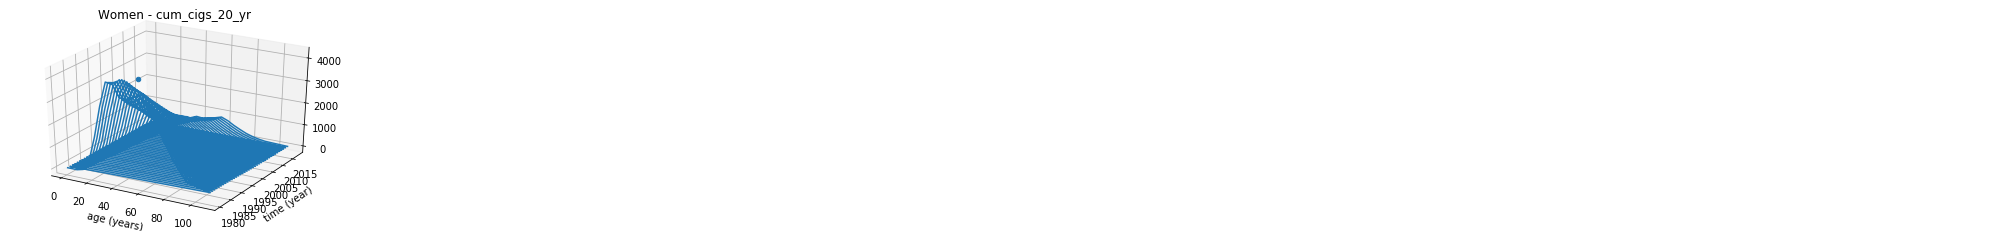

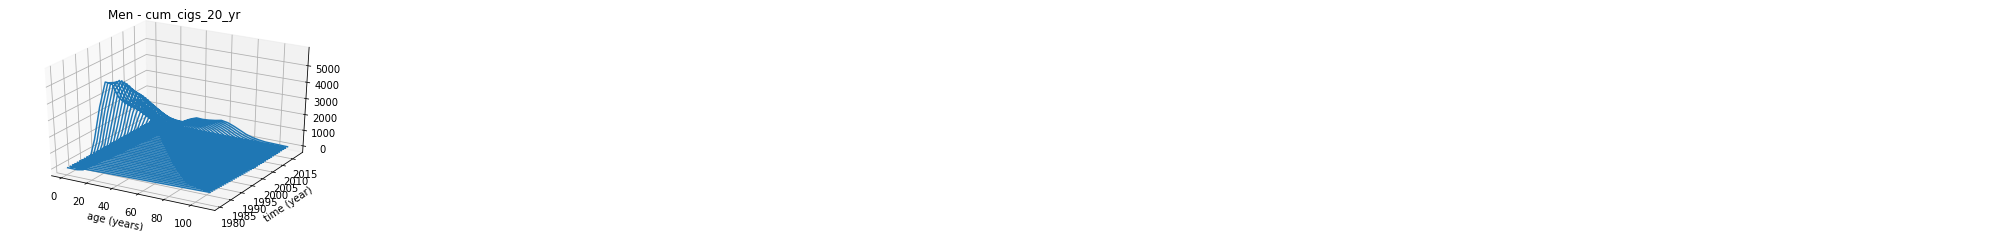

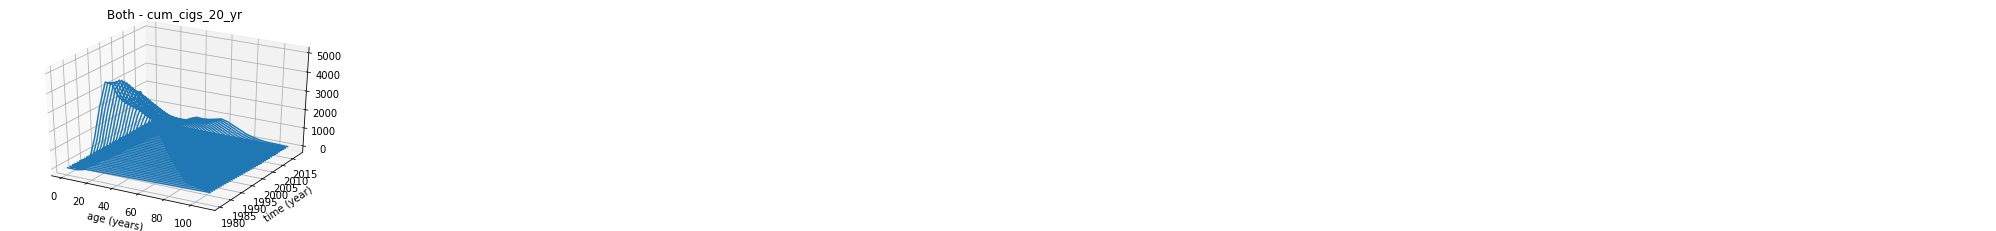

In [103]:
make_at_3D_scatter_plot(cov_f, f"Women - {cov_short_name}")
make_at_3D_scatter_plot(cov_m, f"Men - {cov_short_name}")
make_at_3D_scatter_plot(cov_b, f"Both - {cov_short_name}")

In [92]:
# measurement data
measurements = pd.DataFrame()

# out of range
measurements["age_lower"] = [126, 35, 35, 35, 35]
measurements["age_upper"] = [130, 40, 45, 45, 45]

measurements["time_lower"] = [2000, 1978, 1980, 1990, 2000]
measurements["time_upper"] = [2000, 1978, 1980, 1990, 2000]

measurements["x_sex"] = [0, 0, 0, 0, 0]
sex = pd.Series([0, 0, 0, 0, 0])

cov_col = assign_interpolated_covariate_values(measurements, sex, covariates)

print(f"Age 126-130, out of range, assigned value: {cov_col[0]}\n")
assert np.isnan(cov_col[0])

print(f"Year 1978, out of range, assigned value: {cov_col[1]}\n")
assert np.isnan(cov_col[1])

print(f"Year 1980, out of range, assigned value: {cov_col[2]}\n")

print(f"Year 1990, in range, assigned value: {cov_col[3]}\n")
print(f"Year 1990, in range, assigned value: {cov_col[4]}\n")



Age 126-130, out of range, assigned value: nan

Year 1978, out of range, assigned value: nan

Year 1980, out of range, assigned value: nan

Year 1990, in range, assigned value: 3857.3728106703725

Year 1990, in range, assigned value: 2021.9926580015199



### Example (1D interpolation over time): 
    Covariate data is is not by_sex (has only sex=both), is not by_age (has only one age group -- 22 or 27), and has multiple time values
    
    Measurement data has sex=female, male and both, multiple age values, and multiple time values

In [93]:
# get covariate data
covariates = ccovs[14]
cov_short_name = covariates.loc[0, 'covariate_name_short']

cov_dict = get_covariate_data_by_sex(covariates)

cov_f = cov_dict[FEMALE]
cov_m = cov_dict[MALE]
cov_b = cov_dict[BOTH]

In [94]:
def make_time_2D_scatter_plot(cov, plot_title):
    
    fig = plt.figure()
    
    plt.plot(cov_f["avg_time"], cov_f["mean_value"], 'bo')
    
    plt.title(plot_title)
    plt.xlabel("time (year)")
    plt.ylabel("value")
    
    plt.show()    

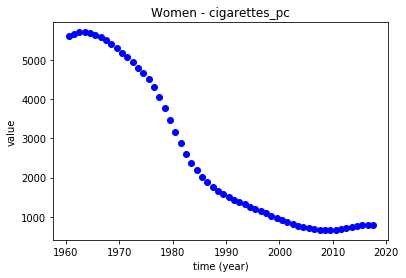

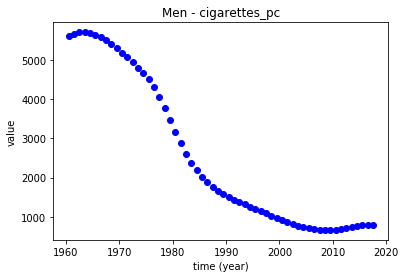

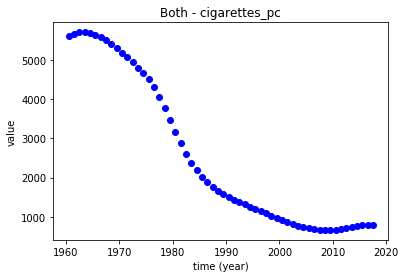

In [95]:
make_time_2D_scatter_plot(cov_f, f"Women - {cov_short_name}")
make_time_2D_scatter_plot(cov_m, f"Men - {cov_short_name}")
make_time_2D_scatter_plot(cov_b, f"Both - {cov_short_name}")

In [100]:
# measurement data
measurements = pd.DataFrame() 

num_sexes = 3

measurements["age_lower"] = num_sexes*[126, 30, 30, 30]
measurements["age_upper"] = num_sexes*[130, 35, 35, 35]

measurements["time_lower"] = num_sexes*[2000, 2020, 1950, 1980]
measurements["time_upper"] = num_sexes*[2000, 2020, 1950, 1980]

num_values = 4

measurements["x_sex"] = num_values*[FEMALE] + num_values*[MALE] + num_values*[BOTH]

sex = pd.Series([0,0])

cov_col = assign_interpolated_covariate_values(measurements, sex, covariates)

measurements["cov_col"] = cov_col

cov_col_f = list(measurements[measurements["x_sex"] == FEMALE].cov_col)
cov_col_m = list(measurements[measurements["x_sex"] == MALE].cov_col)
cov_col_b = list(measurements[measurements["x_sex"] == BOTH].cov_col)

print(cov_col_f)
print(cov_col_m)
print(cov_col_b)

test_cases = ["Age 126-130, out of range, assigned value: ",
              "Year 2020, out of range, assigned value: ",
              "Year 1950, out of range, assigned value: ",
              "Year 1980, in range, assigned value: "
             ]

for test_case in range(0,4):    

    print(test_cases[test_case])    
    print(f"\tfemale: {cov_col_f[test_case]}")
    print(f"\tmale: {cov_col_m[test_case]}")
    print(f"\tboth: {cov_col_b[test_case]}\n")
    
    if test_case < 3:
        assert np.isnan(cov_col_f[test_case])


[nan, nan, nan, 3317.18333548496]
[nan, nan, nan, 3317.18333548496]
[nan, nan, nan, 3317.18333548496]
Age 126-130, out of range, assigned value: 
	female: nan
	male: nan
	both: nan

Year 2020, out of range, assigned value: 
	female: nan
	male: nan
	both: nan

Year 1950, out of range, assigned value: 
	female: nan
	male: nan
	both: nan

Year 1980, in range, assigned value: 
	female: 3317.18333548496
	male: 3317.18333548496
	both: 3317.18333548496



### Example (1D interpolation over time): 
    Covariate is binary, is not by_sex, and is not by_age
    
    Measurement data has sex=female, male and both, multiple age values, and multiple time values

In [105]:
# get covariate data
covariates = ccovs[1241]
cov_short_name = covariates.loc[0, 'covariate_name_short']

cov_dict = get_covariate_data_by_sex(covariates)

cov_f = cov_dict[FEMALE]
cov_m = cov_dict[MALE]
cov_b = cov_dict[BOTH]

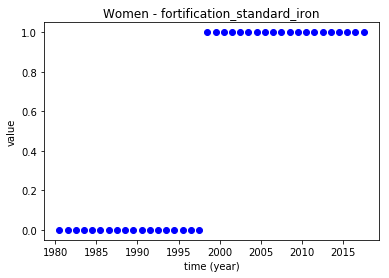

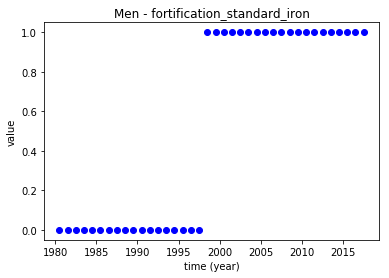

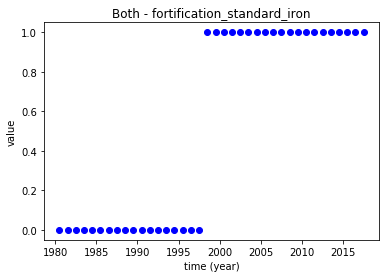

In [72]:
make_time_2D_scatter_plot(cov_f, f"Women - {cov_short_name}")
make_time_2D_scatter_plot(cov_m, f"Men - {cov_short_name}")
make_time_2D_scatter_plot(cov_b, f"Both - {cov_short_name}")

In [111]:
# measurement data
measurements = pd.DataFrame()

# out of range
measurements["age_lower"] = [126, 35, 35, 35, 35, 35, 35, 35]
measurements["age_upper"] = [130, 40, 40, 40, 40, 40, 40, 40]

measurements["time_lower"] = [2000, 1978, 1985, 1997.75, 1998, 1998.25, 1999, 2010]
measurements["time_upper"] = [2000, 1978, 1985, 1997.75, 1998, 1998.25, 1999, 2010]

measurements["x_sex"] = [0, 0, 0, 0, 0, 0, 0, 0]
sex = pd.Series([0,0])

cov_col = assign_interpolated_covariate_values(measurements, sex, covariates)

print(cov_col)

print(f"Age 126-130, out of range, assigned value: {cov_col[0]}\n")
assert np.isnan(cov_col[0])

print(f"Year 1978, out of range, assigned value: {cov_col[1]}")
assert np.isnan(cov_col[1])

0     NaN
1     NaN
2    0.00
3    0.25
4    0.50
5    0.75
6    1.00
7    1.00
dtype: float64
Age 126-130, out of range, assigned value: nan

Year 1978, out of range, assigned value: nan
